In [229]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import geopandas as gp
# import pysal as ps
import seaborn as sb
import folium
import contextily
from sklearn.linear_model import LinearRegression
import pygeohash as gh
import polygeohasher as pg
from sqlalchemy import create_engine
engine = create_engine('sqlite:///save_pandas.db', echo=True)
sqlite_connection = engine.connect()

SyntaxError: invalid syntax (<ipython-input-229-234c6737d574>, line 13)

In [178]:
df = pd.read_csv(Path('./Resources/ibtracs.since1980.list.v04r00.csv'))
df = df.fillna("NA")
df.head()

C:\Users\jbate\anaconda3\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SID,SEASON_Year,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,WMO_AGENCY,DS824_STAGE,DS824_WIND,DS824_PRES,TD9636_LAT,TD9636_LON,TD9636_STAGE,TD9636_WIND_KTS,STORM_SPEED_KTS,STORM_DIR_degrees
0,1980001S13173,1980,1,SP,MM,PENI,1/1/1980 0:00,TS,-12.5000,172.500,...,,TC,25,,-12.5,172.5,1,25,6,351
1,1980001S13173,1980,1,SP,MM,PENI,1/1/1980 3:00,TS,-12.1927,172.441,...,,TC,25,,-12.2234,172.469,1,,6,351
2,1980001S13173,1980,1,SP,MM,PENI,1/1/1980 6:00,TS,-11.9144,172.412,...,,TC,25,,-11.9575,172.45,1,,5,358
3,1980001S13173,1980,1,SP,MM,PENI,1/1/1980 9:00,TS,-11.6863,172.435,...,,TC,25,,-11.7128,172.456,1,,4,12
4,1980001S13173,1980,1,SP,MM,PENI,1/1/1980 12:00,TS,-11.5000,172.500,...,,TC,25,,-11.5,172.5,1,,4,22


In [179]:
df.dtypes

SID                   object
SEASON_Year            int64
NUMBER                 int64
BASIN                 object
SUBBASIN              object
NAME                  object
ISO_TIME              object
NATURE                object
LAT                  float64
LON                  float64
WMO_WIND_KTS          object
WMO_PRES              object
WMO_AGENCY            object
DS824_STAGE           object
DS824_WIND            object
DS824_PRES            object
TD9636_LAT            object
TD9636_LON            object
TD9636_STAGE          object
TD9636_WIND_KTS       object
STORM_SPEED_KTS       object
STORM_DIR_degrees     object
dtype: object

In [180]:
#Drop unnamed storms
indexnames = df[df['NAME'] == 'NOT_NAMED'].index
df.drop(indexnames , inplace=True)
df.head()

,SID,SEASON_Year,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,WMO_AGENCY,DS824_STAGE,DS824_WIND,DS824_PRES,TD9636_LAT,TD9636_LON,TD9636_STAGE,TD9636_WIND_KTS,STORM_SPEED_KTS,STORM_DIR_degrees
0,1980001S13173,1980,1,SP,MM,PENI,1/1/1980 0:00,TS,-12.5000,172.500,...,,TC,25,,-12.5,172.5,1,25,6,351
1,1980001S13173,1980,1,SP,MM,PENI,1/1/1980 3:00,TS,-12.1927,172.441,...,,TC,25,,-12.2234,172.469,1,,6,351
2,1980001S13173,1980,1,SP,MM,PENI,1/1/1980 6:00,TS,-11.9144,172.412,...,,TC,25,,-11.9575,172.45,1,,5,358
3,1980001S13173,1980,1,SP,MM,PENI,1/1/1980 9:00,TS,-11.6863,172.435,...,,TC,25,,-11.7128,172.456,1,,4,12
4,1980001S13173,1980,1,SP,MM,PENI,1/1/1980 12:00,TS,-11.5000,172.500,...,,TC,25,,-11.5,172.5,1,,4,22


In [181]:
df['geohash']=df.apply(lambda x: gh.encode(x.LAT, x.LON, precision=5), axis=1)
df.head()


,SID,SEASON_Year,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,DS824_STAGE,DS824_WIND,DS824_PRES,TD9636_LAT,TD9636_LON,TD9636_STAGE,TD9636_WIND_KTS,STORM_SPEED_KTS,STORM_DIR_degrees,geohash
0,1980001S13173,1980,1,SP,MM,PENI,1/1/1980 0:00,TS,-12.5000,172.500,...,TC,25,,-12.5,172.5,1,25,6,351,rvf8v
1,1980001S13173,1980,1,SP,MM,PENI,1/1/1980 3:00,TS,-12.1927,172.441,...,TC,25,,-12.2234,172.469,1,,6,351,rvfde
2,1980001S13173,1980,1,SP,MM,PENI,1/1/1980 6:00,TS,-11.9144,172.412,...,TC,25,,-11.9575,172.45,1,,5,358,rvfs5
3,1980001S13173,1980,1,SP,MM,PENI,1/1/1980 9:00,TS,-11.6863,172.435,...,TC,25,,-11.7128,172.456,1,,4,12,rvfte
4,1980001S13173,1980,1,SP,MM,PENI,1/1/1980 12:00,TS,-11.5000,172.500,...,TC,25,,-11.5,172.5,1,,4,22,rvfwt


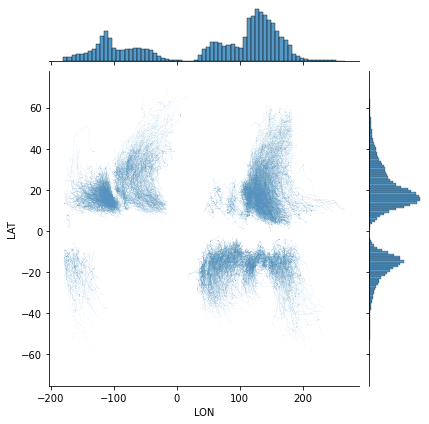

In [182]:
# Generate scatter plot
sb.jointplot(x='LON', y='LAT', data=df, s=0.05);



C:\Users\jbate\anaconda3\envs\PythonData\lib\site-packages\contextily\tile.py:583: RuntimeWarning: divide by zero encountered in log2
  zoom_lon = np.ceil(np.log2(360 * 2.0 / lon_length))


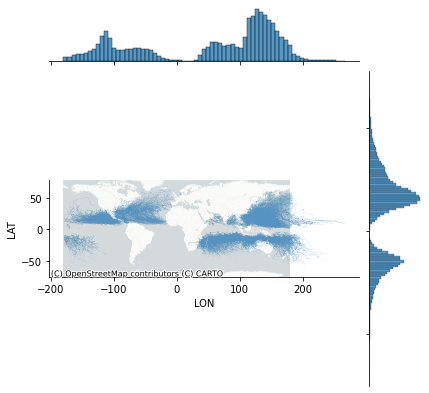

In [183]:
#add basemap with scatterplot

joint_axes = sb.jointplot(
    x='LON', y='LAT', data=df, s=0.05
)
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels
);

In [184]:
#Filter df to North Atlantic(NA) basin
df_NA = df.loc[df['BASIN']=='NA']
df_NA.head()

,SID,SEASON_Year,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,DS824_STAGE,DS824_WIND,DS824_PRES,TD9636_LAT,TD9636_LON,TD9636_STAGE,TD9636_WIND_KTS,STORM_SPEED_KTS,STORM_DIR_degrees,geohash
3212,1980214N11330,1980,57,NA,NA,ALLEN,7/31/1980 12:00,NR,11.0000,-30.0000,...,,,,,,,,22,267,e3fwt
3213,1980214N11330,1980,57,NA,NA,ALLEN,7/31/1980 15:00,NR,10.9509,-31.1101,...,,,,,,,,22,267,e3cyk
3214,1980214N11330,1980,57,NA,NA,ALLEN,7/31/1980 18:00,NR,10.9000,-32.2000,...,,,,,,,,21,267,e3cn5
3215,1980214N11330,1980,57,NA,NA,ALLEN,7/31/1980 21:00,NR,10.8496,-33.2574,...,,,,,,,,21,267,e3bme
3216,1980214N11330,1980,57,NA,NA,ALLEN,8/1/1980 0:00,TS,10.8000,-34.3000,...,,,,,,,,21,267,e1zt7


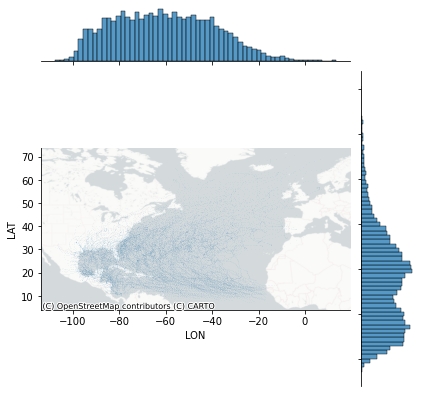

In [185]:
#Map North Atlantic region and add basemap with scatterplot

joint_axes = sb.jointplot(
    x='LON', y='LAT', data=df_NA, s=0.05
)
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels
);

In [129]:
#Save DF to sqlite DB
sqlite_table = "storm_db"
#df.to_sql(sqlite_table, sqlite_connection, if_exists='fail')
df.to_sql(sqlite_table, sqlite_connection, if_exists='replace')

2021-03-02 13:45:52,135 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("storm_db")
2021-03-02 13:45:52,136 INFO sqlalchemy.engine.base.Engine ()
2021-03-02 13:45:52,138 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("storm_db")
2021-03-02 13:45:52,138 INFO sqlalchemy.engine.base.Engine ()
2021-03-02 13:45:52,139 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2021-03-02 13:45:52,140 INFO sqlalchemy.engine.base.Engine ()
2021-03-02 13:45:52,141 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_xinfo("storm_db")
2021-03-02 13:45:52,142 INFO sqlalchemy.engine.base.Engine ()
2021-03-02 13:45:52,145 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
2021-03-02 13:45:52,145 INFO sqlalchemy.engine.base.Engine ('storm_db',)
2021-03-02 13:45:52,147 INFO sqlalchemy.engine.base.Engine PRAGMA main.foreign_key_list(

In [130]:
sqlite_connection.close()

In [7]:
#Plot boundary points for Florida
import geopandas as gpd
from shapely.geometry import Polygon

lat_point_list = [-87.43, -81.81, -79.28, -81.43]
lon_point_list = [30.3, 24.56, 25.56, 30.67]

polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
crs = {'init': 'epsg:4326'}
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])       
print(polygon.geometry)

polygon.to_file(filename='polygon.geojson', driver='GeoJSON')
polygon.to_file(filename='polygon.shp', driver="ESRI Shapefile")



0    POLYGON ((30.30000 -87.43000, 24.56000 -81.810...
Name: geometry, dtype: geometry


In [10]:
#Verify coordinates on map

import folium
import pandas as pd
 
# Make a data frame with coordinates to show on the map
FL_data = pd.DataFrame({
# 'lat':[30.3, 24.56, 25.56, 30.67],
# 'lon':[-87.43, -81.81, -79.28, -81.43],
    
'lat':[-87.43, -81.81, -79.28, -81.43],
'lon':[30.3, 24.56, 25.56, 30.67],
    
'name':['Pensacola', 'Key West', 'Cat Cay', 'Jacksonville']
})
FL_data
 
# Make an empty map
m = folium.Map(location=[27, -84], tiles="cartodbpositron", zoom_start=5)
 
# I can add marker one by one on the map
for i in range(0,len(FL_data)):
    folium.Marker([FL_data.iloc[i]['lon'], FL_data.iloc[i]['lat']], popup=FL_data.iloc[i]['name']).add_to(m)
m


In [134]:
#Get Geohash data for FL boundaries
#Also rename columns to match storm data
FL_data = FL_data.rename(columns={'lat': 'LAT', 'lon':'LON'})
FL_data['geohash']=FL_data.apply(lambda x: gh.encode(x.LAT, x.LON, precision=5), axis=1)
FL_data

,LAT,LON,name,geohash
0,-87.43,30.30,Pensacola,h8mw9
1,-81.81,24.56,Key West,h93qw
2,-79.28,25.56,Cat Cay,h9fhv
3,-81.43,30.67,Jacksonville,h9tbc


In [205]:
#Import FL geojson
fname = "./Resources/gz_2010_us_040_00_500k.json"

df_US = gp.read_file(fname)

print(type(df_US))

df_US.head(5)

<class 'geopandas.geodataframe.GeoDataFrame'>


,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US23,23,Maine,,30842.923,"MULTIPOLYGON (((-67.61976 44.51975, -67.61541 ..."
1,0400000US25,25,Massachusetts,,7800.058,"MULTIPOLYGON (((-70.83204 41.60650, -70.82373 ..."
2,0400000US26,26,Michigan,,56538.901,"MULTIPOLYGON (((-88.68443 48.11579, -88.67563 ..."
3,0400000US30,30,Montana,,145545.801,"POLYGON ((-104.05770 44.99743, -104.25015 44.9..."
4,0400000US32,32,Nevada,,109781.180,"POLYGON ((-114.05060 37.00040, -114.04999 36.9..."


In [208]:
df_FL = df_US.loc[df_US['NAME'] == 'Florida']
df_FL

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
27,0400000US12,12,Florida,,53624.759,"MULTIPOLYGON (((-85.15641 29.67963, -85.13740 ..."


In [214]:
df_FL.dtypes




GEO_ID          object
STATE           object
NAME            object
LSAD            object
CENSUSAREA     float64
geometry      geometry
dtype: object

In [217]:
df_FL['geometry'].head()

27    MULTIPOLYGON (((-85.15641 29.67963, -85.13740 ...
Name: geometry, dtype: geometry

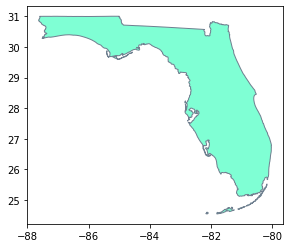

In [226]:
ax = df_FL.plot(
color='aquamarine', edgecolor='slategrey')
#gp.plot(ax=ax)

In [228]:
FLghash_df = pg.create_geohash_list(df_FL, 5,inner=False)

AttributeError: module 'polygeohasher' has no attribute 'create_geohash_list'

In [235]:
df_FL.to_csv('df_FL.csv', columns=['geometry'],index=False)

In [236]:
df_FL = pd.read_csv(Path('./Resources/FL_LAT_LON.csv'))
df_FL.head()

,1,-85.137397,29.684348
0,2,-85.134639,29.686569
1,3,-85.114268,29.688658
2,4,-85.093902,29.684838
3,5,-85.083719,29.679019
4,6,-85.077237,29.670862


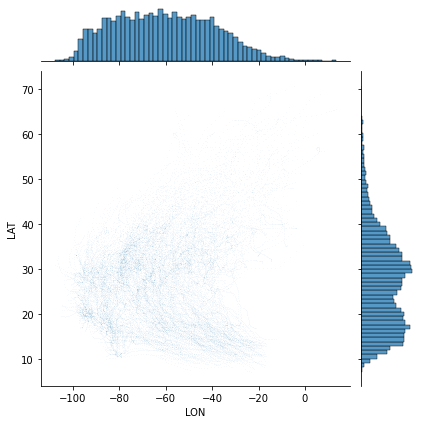

In [237]:
#Map North Atlantic region and add basemap with scatterplot

joint_axes = sb.jointplot(
    x='LON', y='LAT', data=df_NA, s=0.05
)
# contextily.add_basemap(
#     joint_axes.ax_joint,
#     crs="EPSG:4326",
#     source=contextily.providers.CartoDB.PositronNoLabels
# );

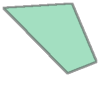

In [159]:
from polygon_geohasher.polygon_geohasher import polygon_to_geohashes, geohashes_to_polygon
from shapely import geometry

# polygon = geometry.Polygon([(-99.1795917, 19.432134), (-99.1656847, 19.429034),
#                             (-99.1776492, 19.414236), (-99.1795917, 19.432134)])

polygon = geometry.Polygon([(-87.430000, 30.300000), (-81.810000, 24.560000),
                            (-79.280000, 25.560000), (-81.430000, 30.670000)])

# 'lat':[-87.43, -81.81, -79.28, -81.43],
# 'lon':[30.3, 24.56, 25.56, 30.67],
inner_geohashes_polygon = geohashes_to_polygon(polygon_to_geohashes(polygon, 5,))
outer_geohashes_polygon = geohashes_to_polygon(polygon_to_geohashes(polygon, 5, False))

inner_geohashes_polygon
outer_geohashes_polygon


In [155]:
import geohash
import shapely
from shapely.geometry import Point
unchecked = set()
inside = set()
outside = set()
pt=0
bbox_pts = pt[0[-87.43, 30.3]], pt[1[-81.81, 24.56]], pt[2[-79.28, 25.56]], pt[3[-81.43, 30.67]]
for pt in bbox_pts:
    tst_gh = geohash.encode(pt[0], pt[1], pt[2], pt[3], 5)
    unchecked.add(tst_gh)

    bbox = shapely.geometry.Polygon(bbox_pts)
    while unchecked:
        this = unchecked.pop()

TypeError: 'int' object is not subscriptable